In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add local scripts to path
import os,sys
sys.path.insert(0,os.path.abspath("./"))
import neurotools

# Set up cache
from neurotools.jobs.initialize_system_cache import initialize_caches,cache_test
PYCACHEDIR = os.path.abspath('./')
CACHENAME  = 'PPC_cache'
from neurotools.tools import ensure_dir
ensure_dir(PYCACHEDIR+os.sep+CACHENAME)
initialize_caches(
    level1  = PYCACHEDIR,
    force   = False,
    verbose = False,
    CACHE_IDENTIFIER = CACHENAME)

# Import libraries
from neurotools.nlab import *
import ppc_data_loader

# Set this to the location of the PPC data on your machine
ppc_data_loader.path = '/home/mer49/Dropbox (Cambridge University)/Datasets/PPC_data/'
from ppc_data_loader   import *
from ppc_trial         import *

# Configure numpy
from numpy.linalg import solve
np.seterr(all='ignore')
np.set_printoptions(precision=3)
import warnings
warnings.filterwarnings("ignore","scipy")
print('Numpy configured')

# Configure Matplotlib
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
TEXTWIDTH = 5.62708
matplotlib.rcParams['figure.figsize'] = (TEXTWIDTH, TEXTWIDTH/sqrt(2))
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore",category=MatplotlibDeprecationWarning)
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
matplotlib.rc('font' , size   =SMALL_SIZE ) # controls default text sizes
matplotlib.rc('axes' , titlesize=MEDIUM_SIZE) # fontsize of the axes title
matplotlib.rc('axes' , labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
matplotlib.rc('xtick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('ytick' , labelsize=SMALL_SIZE ) # fontsize of the tick labels
matplotlib.rc('legend', fontsize =SMALL_SIZE ) # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
matplotlib.rc('lines' , solid_capstyle='round')
plt.rcParams['image.cmap'] = 'parula'
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=[BLACK,RUST,TURQUOISE,OCHRE,AZURE,MAUVE])
matplotlib.rc('savefig',dpi=240)
print('Matplotlib configured')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Numpy configured
Matplotlib configured


In [5]:
# Two simulations were run
# They are the same so you can pool for slightly nicer result
# by setting USE_DATASET==[1,2]
# But we only use [2] for the figure in the paper
USE_DATASET = [1,2] 

data = []
if 1 in USE_DATASET:
    filename = "./datafiles/F4S1_DVR_rankVsDeg.mat"
    from h5py import *
    from neurotools.hdfmat import *
    df = h5py.File(filename, "r")
    recursive_printmatHDF5(df)
    rankVsDeg = getHDF(df,'rankVsDeg')
    print(getHDF(rankVsDeg,'data_dimensions'))
    ranks                  = getHDF(rankVsDeg,'ranks')
    true_mouse_degradation = getHDF(rankVsDeg,'true_mouse_degradation')
    days_per_mouse         = getHDF(rankVsDeg,'days_per_mouse')
    data                  += [getHDF(rankVsDeg,'data')]
    print(days_per_mouse)
    
if 2 in USE_DATASET:
    filename = "./datafiles/F4S1_DVR_rankVsDeg_v2.mat"
    rankVsDeg = scipy.io.loadmat(filename)['rankVsDeg'][0][0]
    data_dimensions2        = rankVsDeg[0]
    days_per_mouse2         = rankVsDeg[1]
    data                   += [rankVsDeg[2].transpose(2,1,0)]
    true_mouse_degradation2 = rankVsDeg[3]

data = cat(data,axis=0)

 rankVsDeg:
 :  | data                   | 8 x 14 x 4 | float64 | 'numpy.ndarray | 
 :  | data_dimensions        | 39 x 1     | uint16  | 'numpy.ndarray | 
 :  | days_per_mouse         | 4          | int64   | 'numpy.ndarray | 
 :  | ranks                  | 14         | int64   | 'numpy.ndarray | 
 :  | true_mouse_degradation | 4          | float64 | 'numpy.ndarray | 
4 mice by 14 ranks to test by 8 repeats
[10 12 10  5]


## Render the figure

22.387262298981828
15.507358042938796
26.71733648573219


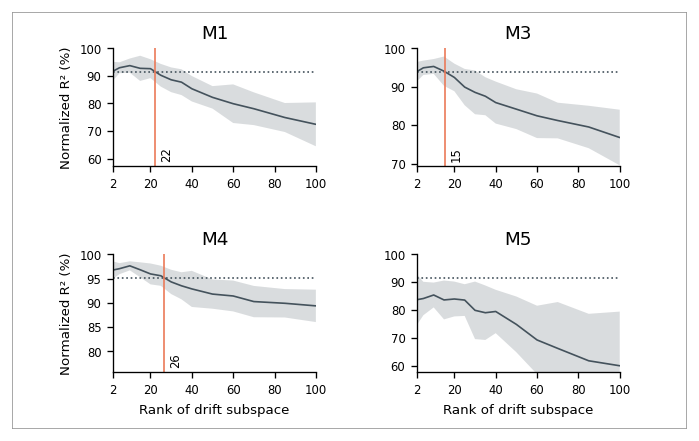

In [6]:
figure(figsize=(TEXTWIDTH,TEXTWIDTH*(sqrt(5)-1)/2))
mice = (1,3,4,5)
for i,mouse in enumerate(mice):
    subplot(2,2,i+1)
    d = data[:,:,i]*100
    n = d.shape[0]
    μ = mean(d,axis=0)
    σ = std (d,axis=0)
    e = 1.96*σ
    plot(ranks,μ,lw=1)
    fill_between(ranks,μ-e,μ+e,alpha=0.2,lw=0)
    simpleaxis()
    title('M%d'%mouse,fontsize=11)
    if i in (2,3):
        xlabel('Rank of drift subspace')
    if i in (0,2):
        ylabel('Normalized R² (%)')
    t = true_mouse_degradation[i]
    axhline(t,lw=1,linestyle=':')
    xticks([2,20,40,60,80,100])
    y0 = 100 - (100-t)*5
    ylim(y0,100)
    crosses = find(diff(int32(μ>t))==-1)
    if len(crosses)==1:
        crosses = crosses[0]
        a,b = μ[crosses:][:2]
        c,d = ranks[crosses:][:2]
        u = d + (c-d)*(t-b)/(a-b)
        print(u)
        axvline(u,color=RUST,lw=1)
        text(u+px2x(5),ylim()[0]+px2y(5),'%2d'%u,rotation=90,va='bottom',ha='left')
        
tight_layout()
subplots_adjust(left=0.15,right=0.9,wspace=0.5,hspace=0.75)
savefig('F3S1.pdf')
savefig('F3S1.png',dpi=600)
figurebox()
savefig('F3S1.svg')